# Final Project
## Planetary BestHealthCare Insurance Company Incorporated
### Boran and Radan initial exploratory analysis report

Lipscomb University

MSDS 5013

Caleb Chronowski, Krishawn Nolan, Tory Legg

September 24, 2020

In [1]:
# dependencies
from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np

### Initial data pre-processing
The SQL code for initializing the databse contained in `/database/PlanetMedical.db` can be found in the `/database` directory along with SQL for combining the data used in this analysis. The data used for this analysis was then exported from that database as a .csv file and imported into this notebook with the code below.

There also is a SQLAlchemy Jupyter Notebook that demonstrates how to create the database, insert external data into the database, compile a table of the data needed for analysis and read that data into a DataFrame all entirely in Python. That can be found in `/scripts/create_db.ipynb`.

In [2]:
# file paths
full_dataPath = Path("./resources/full_data.csv")

In [3]:
# data import
df = pd.read_csv(full_dataPath).set_index('patient_id')
df['planet_id'] = df['planet_id'].replace({1:'Boran',2:'Radan'})
df.head()

,age,blood_pressure,exercise,weight,glucose,BMI,planet_id
patient_id,,,,,,,
5231,75.254768,194.639537,45.811801,145.294390,122.231550,1.005604,Boran
5502,78.425828,102.743158,43.031599,81.072209,77.593129,0.984347,Radan
8248,74.242965,189.628666,90.167716,139.689556,118.206986,0.972132,Boran
8495,79.982882,101.532439,84.264034,77.931413,75.550277,0.963410,Radan
8499,85.809577,104.635367,75.525589,82.481703,79.318150,1.021250,Radan


### Histogram of age distribution on each planet.
Radan patients generally live longer than Boran patients. Interestingly enough, the patients on Radan are more likely to die before reaching their average life expectancy. The patients on Boran are actually equally likely to live longer or shorter than the average life expectancy. The mean life expectancies for these planets are 76.42 years on Boran and 84.22 years on Radan.

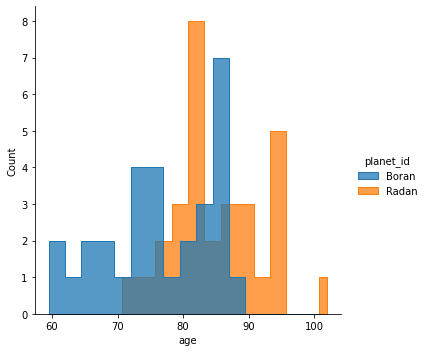

In [4]:
sns.displot(df, x='age', binwidth=2.5, hue='planet_id', element="step", multiple="dodge")

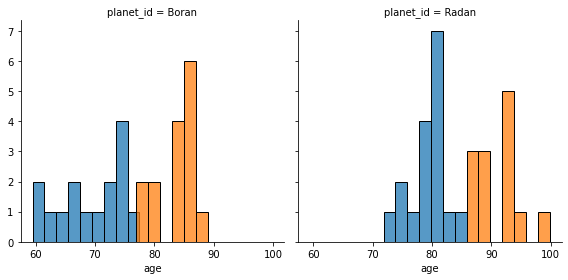

In [5]:
# Average value by planet for age
df_mean = df.groupby('planet_id').agg(np.mean)

# Function to check if patient's age is over or under life expectancy
def life_expectancy_check(age, planet_id):
    life_expectancy = df_mean['age'][planet_id]
    if age >= life_expectancy:
        return 1
    else:
        return 0

# Create new binary column to store whether or not patient exceeded average age
df['over_life_expectancy'] = df.apply(lambda x: life_expectancy_check(x['age'], x['planet_id']), axis=1)

g = sns.FacetGrid(df, col="planet_id", hue="over_life_expectancy", height=4)
g.map(sns.histplot, 'age', binwidth=2)

In [6]:
df[['over_life_expectancy','planet_id']].head()

,over_life_expectancy,planet_id
patient_id,,
5231,0,Boran
5502,0,Radan
8248,0,Boran
8495,0,Radan
8499,1,Radan


In [7]:
df_life_expectancy = df[['planet_id', 'over_life_expectancy']].pivot_table(index='planet_id',
                                                                           columns='over_life_expectancy',
                                                                           aggfunc='size')
df_life_expectancy

over_life_expectancy,0,1
planet_id,,
Boran,15,15
Radan,17,13


### Blood pressure boxplot
The distribution of blood pressures is much wider on Boran, but that makes sense given how much higher the mean blood pressure is. Neither planet had any notable outliers. I'm wondering if Boran has stronger gravity and/or higher atmospheric pressure. That could lead to higher blood pressures.

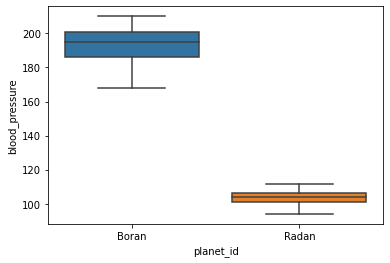

In [8]:
sns.boxplot(x='planet_id', y='blood_pressure', data=df)

Because the mean blood pressure on Boran is almost double the mean blood pressure on Radan, this graph makes it very clear that the planet a patient is on has a strong effect on what their blood pressure might be.

However, when comparing blood pressures between Boran and Radan, it is very difficult to see how the variations within each of the two populations compare to one another. I want to transform the graph so that the box plots show the relative distributions of each planet in such a way that the mean of both plots lines up. I will create a `blood_pressure_dev` attribute that measures how many standard deviations from the blood pressure mean each point is. I'll then plot the new column with both box plots, and smoothed kde.

In [9]:
# Data frame to hold standard deviations
df_std_dev = df.groupby('planet_id').agg(np.std)

# Function to check if patient's age is over or under life expectancy
def bp_dev(bp, planet_id):
    std_dev = df_std_dev['blood_pressure'][planet_id]
    bp_mean = df_mean['blood_pressure'][planet_id]
    return ((bp-bp_mean)/std_dev)

# Create new column
df['blood_pressure_dev'] = df.apply(lambda x: bp_dev(x['blood_pressure'], x['planet_id']), axis=1)
df[['blood_pressure_dev','planet_id']].head()

,blood_pressure_dev,planet_id
patient_id,,
5231,0.093717,Boran
5502,-0.173020,Radan
8248,-0.372636,Boran
8495,-0.456428,Radan
8499,0.269913,Radan


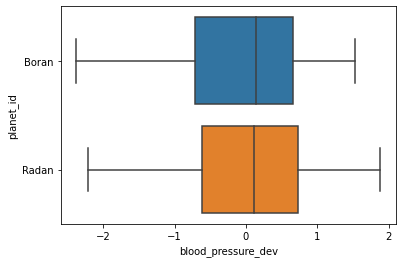

In [10]:
g = sns.boxplot(y='planet_id', x='blood_pressure_dev', orient='h', data=df)

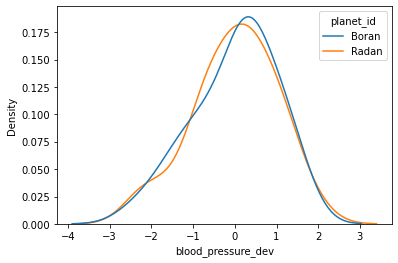

In [11]:
sns.kdeplot(data=df, x="blood_pressure_dev", hue="planet_id")

### Comments on the relative distribution
Both planets have a left skew, but Boran's skew is slightly more pronounced than the skew on Radan. The distributions are actually quite similar when they're normalized in this way.

### Blood Pressure scatterplots
Blood pressure has really strong correlations between weight, glucose and BMI. There's clear colinearity. There's a weaker correlation with age, but it's still visible. The data is much noisier for exercise.

On Earth, the largest animals have the highest blood pressures. The highest blood pressure of all is found in the giraffe which needs 300 mmHg of systolic blood pressure in order for the blood to be able to reach its brain on the top of its incredibly long neck. Boran has high blood pressure and high weight, so I am guessing these aliens may be rather large. The lower a planet's gravity, the more likely it would be that the animals on that planet could grow to be very large. Converseley, planets with very high gravities would prevent animals from becoming large. Perhaps the low gravity and large size of the species on Boran are the reason that exercise levels seem to have basically no correlation with Boran patient's longevity. How effective can exercise be in lower gravity?

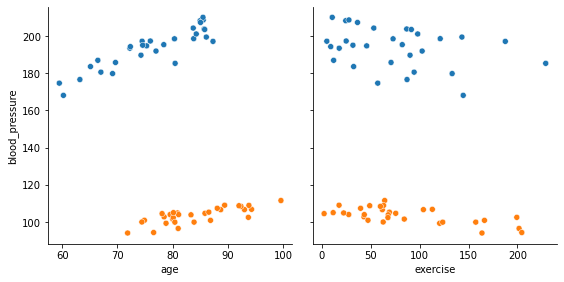

In [12]:
g = sns.PairGrid(data=df, y_vars=["blood_pressure"], x_vars=["age","exercise"], hue="planet_id", height=4)
g.map(sns.scatterplot)

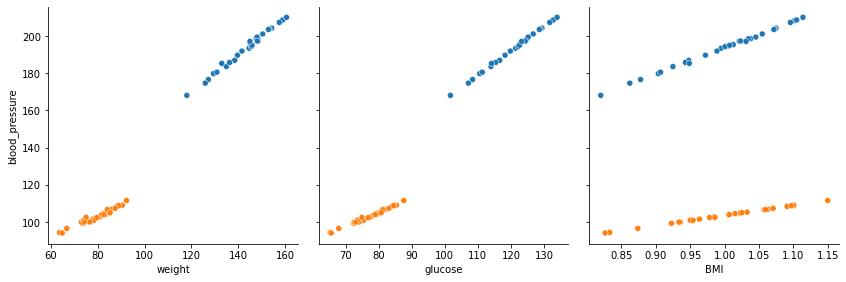

In [13]:
g = sns.PairGrid(data=df, y_vars=["blood_pressure"], x_vars=["weight","glucose","BMI"], hue="planet_id", height=4)
g.map(sns.scatterplot)

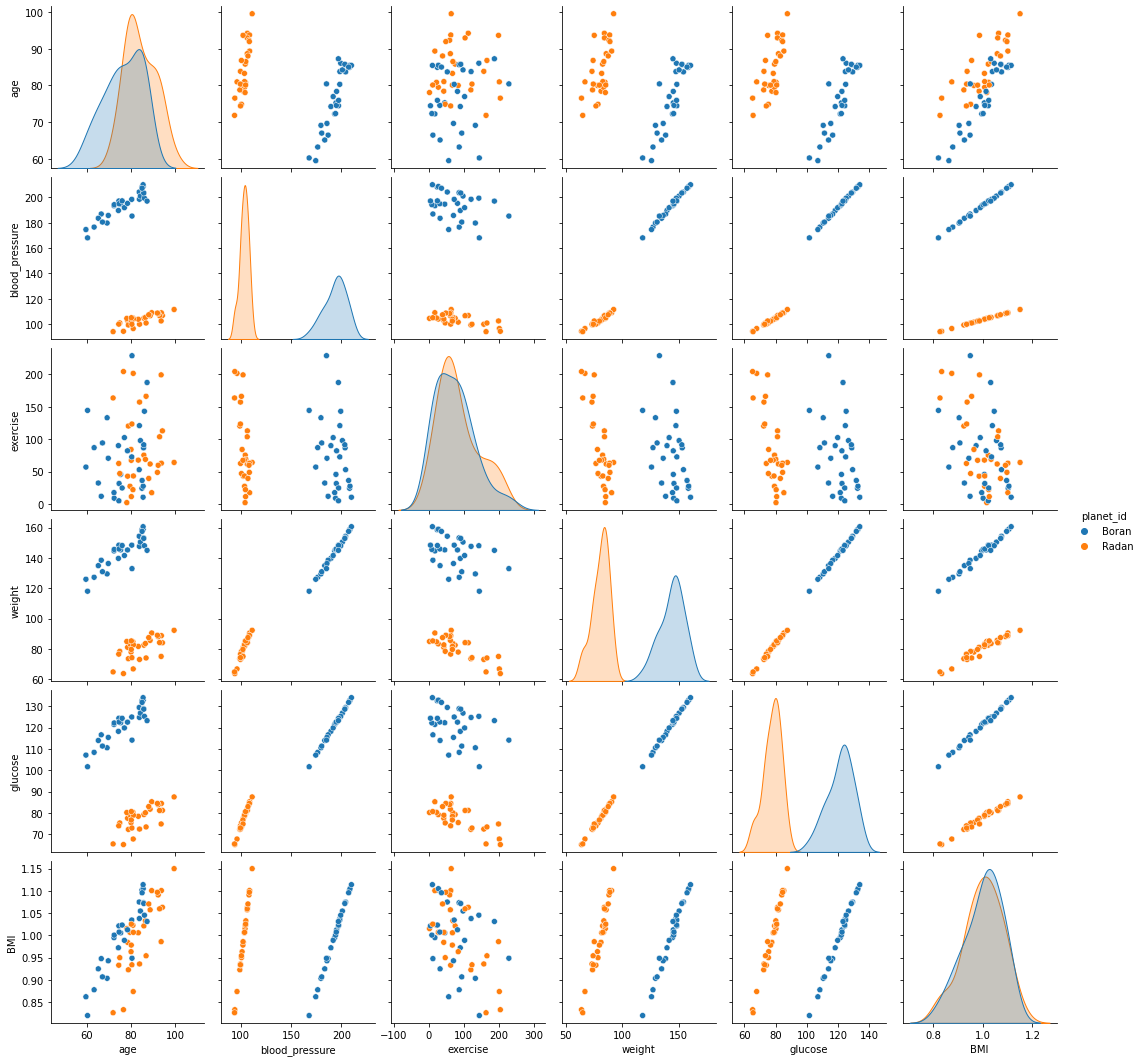

In [14]:
df = df.drop(columns=['blood_pressure_dev','over_life_expectancy'])
sns.pairplot(df, hue="planet_id")

# Conclusion
Weight and BMI have a strong linear relationship, but it's not totally linear. There must be some small variation of densities among patients. Both of these variables along with glucose and blood pressure are linearly related with how long a patient will live. A major bservation that I can see here is that weight/glucose/bmi are all directly related and they're linearly proportional to a patient's blood pressure. The bigger they are, the higher the blood pressure. Higher age has a positive effect on blood pressure as well, but it's less pronounced. This also means that astonishingly, the patients with high blood pressure live longer! Exercise seems to have almost no correlation to blood pressure whatsoever, or perhaps a weak inverse relationship.

High blood pressure, high weight, high glucose and high BMI are all strong predictors for a long life. All of this holds equally true on both Boran and Radan.
